In [1]:
import skimage.io
import skimage.color
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

C:\Users\Lenovo\Anaconda3\envs\mytensor\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


img.shape: (29, 16, 3)


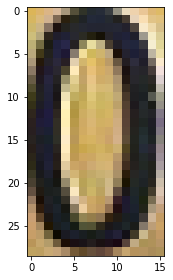

In [5]:
############################################################################
# เปิดภาพตัวอย่างมาหนึ่งไฟล์
############################################################################
img = skimage.io.imread(r'F:\Alex\LLPR\lao-license-plate-using-mask-rcnn\dataset\ann\0\IMG_0004.jpg')
print(F'img.shape: {img.shape}')
skimage.io.imshow(img)

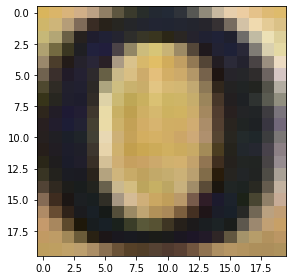

In [6]:
############################################################################
# ทำการ resize (20,20,3)
############################################################################
img2 = skimage.transform.resize(img, (20,20,3))
skimage.io.imshow(img2)

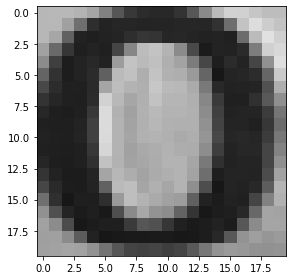

In [7]:
############################################################################
# ทำ grayscale
############################################################################
img2g = skimage.color.rgb2gray(img2)
skimage.io.imshow(img2g)

In [16]:
#######################################################
# - อ่านไฟล์ภาพ
# - resize ภาพให้มีขนาด 20x20x3
# - convert จาก RGB เป็น Gray scale
#######################################################

DATASET_DIR = (r'F:\Alex\LLPR\lao-license-plate-using-mask-rcnn\dataset\ann')

classes = os.listdir(DATASET_DIR)
data = []

for cls in classes:
  class_dir = os.path.join(DATASET_DIR, cls)
  files = os.listdir(class_dir)
  for f in files:
    img = skimage.io.imread(os.path.join(class_dir, f))
    img2 = skimage.transform.resize(img, (20,20,3))
    img = skimage.color.rgb2gray(img2)
    data.append({
        'x': img,
        'y': cls
    })
    
random.shuffle(data)

In [17]:
#DATASET_DIR = '../dataset/carplate'

#classes = os.listdir(DATASET_DIR + "/ann/")
#data = []
#for cls in classes:
#    files = os.listdir(DATASET_DIR + "/ann/"+cls)
#    for f in files:
#        img = skimage.io.imread(DATASET_DIR + "/ann/"+cls+"/"+f)
#        img = skimage.color.rgb2gray(img)
#        data.append({
#            'x': img,
#            'y': cls
#        })

#random.shuffle(data)

In [18]:
X = [d['x'] for d in data]
y = [d['y'] for d in data]

ys = list(np.unique(y))
y = [ys.index(v) for v in y]

x_train = np.array(X[:int(len(X)*0.8)])
y_train = np.array(y[:int(len(X)*0.8)])

x_test = np.array(X[int(len(X)*0.8):])
y_test = np.array(y[int(len(X)*0.8):])

In [19]:
batch_size = 128
num_classes = len(classes)
epochs = 10

# input image dimensions
img_rows, img_cols = 20, 20

In [20]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

x_train = extend_channel(x_train)
x_test = extend_channel(x_test)

input_shape = x_train.shape[1:]

In [21]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train2 = keras.utils.to_categorical(y_train, num_classes)
y_test2 = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (7437, 20, 20, 1)
7437 train samples
1860 test samples


In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train2,
          batch_size=batch_size,
          epochs=1000,
          #epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test2))

Train on 7437 samples, validate on 1860 samples
Epoch 1/1000
7437/7437 [==============================] - 3s 399us/step - loss: 2.7501 - acc: 0.1234 - val_loss: 2.5508 - val_acc: 0.1382
Epoch 2/1000
7437/7437 [==============================] - 3s 339us/step - loss: 2.5380 - acc: 0.1338 - val_loss: 2.5055 - val_acc: 0.1382
Epoch 3/1000
7437/7437 [==============================] - 3s 338us/step - loss: 2.5143 - acc: 0.1310 - val_loss: 2.5066 - val_acc: 0.1371
Epoch 4/1000
7437/7437 [==============================] - 3s 340us/step - loss: 2.5046 - acc: 0.1372 - val_loss: 2.5234 - val_acc: 0.1371
Epoch 5/1000
7437/7437 [==============================] - 3s 340us/step - loss: 2.4998 - acc: 0.1335 - val_loss: 2.5086 - val_acc: 0.1371
Epoch 6/1000
7437/7437 [==============================] - 3s 339us/step - loss: 2.4975 - acc: 0.1401 - val_loss: 2.5331 - val_acc: 0.1371
Epoch 7/1000
7437/7437 [==============================] - 3s 341us/step - loss: 2.4934 - acc: 0.1428 - val_loss: 2.4988 - va

7437/7437 [==============================] - 3s 337us/step - loss: 0.0946 - acc: 0.9710 - val_loss: 0.0710 - val_acc: 0.9828
Epoch 60/1000
7437/7437 [==============================] - 3s 339us/step - loss: 0.0876 - acc: 0.9740 - val_loss: 0.0724 - val_acc: 0.9828
Epoch 61/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0957 - acc: 0.9716 - val_loss: 0.0767 - val_acc: 0.9839
Epoch 62/1000
7437/7437 [==============================] - 3s 340us/step - loss: 0.0873 - acc: 0.9735 - val_loss: 0.0693 - val_acc: 0.9839
Epoch 63/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0895 - acc: 0.9749 - val_loss: 0.0676 - val_acc: 0.9839
Epoch 64/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0864 - acc: 0.9740 - val_loss: 0.0698 - val_acc: 0.9844
Epoch 65/1000
7437/7437 [==============================] - 3s 339us/step - loss: 0.0915 - acc: 0.9720 - val_loss: 0.0709 - val_acc: 0.9839
Epoch 66/1000
7437/7437 [================

Epoch 118/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0609 - acc: 0.9812 - val_loss: 0.0591 - val_acc: 0.9876
Epoch 119/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0575 - acc: 0.9824 - val_loss: 0.0583 - val_acc: 0.9887
Epoch 120/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0576 - acc: 0.9817 - val_loss: 0.0582 - val_acc: 0.9871
Epoch 121/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0528 - acc: 0.9843 - val_loss: 0.0587 - val_acc: 0.9876
Epoch 122/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0530 - acc: 0.9841 - val_loss: 0.0685 - val_acc: 0.9871
Epoch 123/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0613 - acc: 0.9824 - val_loss: 0.0589 - val_acc: 0.9860
Epoch 124/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0576 - acc: 0.9824 - val_loss: 0.0582 - val_acc: 0.9871
Epoch 125/1000
7437/

7437/7437 [==============================] - 3s 337us/step - loss: 0.0448 - acc: 0.9853 - val_loss: 0.0591 - val_acc: 0.9882
Epoch 177/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0412 - acc: 0.9867 - val_loss: 0.0600 - val_acc: 0.9887
Epoch 178/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0467 - acc: 0.9853 - val_loss: 0.0644 - val_acc: 0.9876
Epoch 179/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0396 - acc: 0.9867 - val_loss: 0.0634 - val_acc: 0.9876
Epoch 180/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0458 - acc: 0.9857 - val_loss: 0.0592 - val_acc: 0.9882
Epoch 181/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0460 - acc: 0.9856 - val_loss: 0.0593 - val_acc: 0.9882
Epoch 182/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0405 - acc: 0.9862 - val_loss: 0.0598 - val_acc: 0.9903
Epoch 183/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0311 - acc: 0.9896 - val_loss: 0.0618 - val_acc: 0.9903
Epoch 235/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0357 - acc: 0.9890 - val_loss: 0.0585 - val_acc: 0.9887
Epoch 236/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0403 - acc: 0.9874 - val_loss: 0.0619 - val_acc: 0.9871
Epoch 237/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0380 - acc: 0.9883 - val_loss: 0.0536 - val_acc: 0.9898
Epoch 238/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0366 - acc: 0.9886 - val_loss: 0.0587 - val_acc: 0.9892
Epoch 239/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0382 - acc: 0.9862 - val_loss: 0.0598 - val_acc: 0.9892
Epoch 240/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0335 - acc: 0.9910 - val_loss: 0.0596 - val_acc: 0.9876
Epoch 241/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0336 - acc: 0.9888 - val_loss: 0.0604 - val_acc: 0.9887
Epoch 293/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0299 - acc: 0.9914 - val_loss: 0.0552 - val_acc: 0.9919
Epoch 294/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0297 - acc: 0.9890 - val_loss: 0.0577 - val_acc: 0.9892
Epoch 295/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0289 - acc: 0.9911 - val_loss: 0.0550 - val_acc: 0.9919
Epoch 296/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0310 - acc: 0.9903 - val_loss: 0.0579 - val_acc: 0.9887
Epoch 297/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0304 - acc: 0.9910 - val_loss: 0.0548 - val_acc: 0.9903
Epoch 298/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0321 - acc: 0.9905 - val_loss: 0.0563 - val_acc: 0.9892
Epoch 299/1000
7437/7437 [=========

7437/7437 [==============================] - 2s 325us/step - loss: 0.0287 - acc: 0.9910 - val_loss: 0.0574 - val_acc: 0.9892
Epoch 351/1000
7437/7437 [==============================] - 2s 325us/step - loss: 0.0240 - acc: 0.9930 - val_loss: 0.0623 - val_acc: 0.9892
Epoch 352/1000
7437/7437 [==============================] - 2s 325us/step - loss: 0.0232 - acc: 0.9935 - val_loss: 0.0558 - val_acc: 0.9898
Epoch 353/1000
7437/7437 [==============================] - 2s 327us/step - loss: 0.0247 - acc: 0.9914 - val_loss: 0.0587 - val_acc: 0.9903
Epoch 354/1000
7437/7437 [==============================] - 2s 328us/step - loss: 0.0248 - acc: 0.9913 - val_loss: 0.0620 - val_acc: 0.9882
Epoch 355/1000
7437/7437 [==============================] - 3s 351us/step - loss: 0.0257 - acc: 0.9923 - val_loss: 0.0655 - val_acc: 0.9882
Epoch 356/1000
7437/7437 [==============================] - 3s 341us/step - loss: 0.0258 - acc: 0.9917 - val_loss: 0.0584 - val_acc: 0.9898
Epoch 357/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0229 - acc: 0.9927 - val_loss: 0.0649 - val_acc: 0.9892
Epoch 409/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0259 - acc: 0.9921 - val_loss: 0.0614 - val_acc: 0.9903
Epoch 410/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0214 - acc: 0.9922 - val_loss: 0.0585 - val_acc: 0.9903
Epoch 411/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0180 - acc: 0.9949 - val_loss: 0.0674 - val_acc: 0.9898
Epoch 412/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0243 - acc: 0.9922 - val_loss: 0.0581 - val_acc: 0.9898
Epoch 413/1000
7437/7437 [==============================] - 3s 339us/step - loss: 0.0218 - acc: 0.9931 - val_loss: 0.0576 - val_acc: 0.9919
Epoch 414/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0259 - acc: 0.9907 - val_loss: 0.0574 - val_acc: 0.9898
Epoch 415/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0218 - acc: 0.9929 - val_loss: 0.0663 - val_acc: 0.9887
Epoch 467/1000
7437/7437 [==============================] - 3s 342us/step - loss: 0.0168 - acc: 0.9950 - val_loss: 0.0588 - val_acc: 0.9909
Epoch 468/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0226 - acc: 0.9935 - val_loss: 0.0555 - val_acc: 0.9903
Epoch 469/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0599 - val_acc: 0.9903
Epoch 470/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0210 - acc: 0.9939 - val_loss: 0.0579 - val_acc: 0.9903
Epoch 471/1000
7437/7437 [==============================] - 3s 343us/step - loss: 0.0228 - acc: 0.9921 - val_loss: 0.0608 - val_acc: 0.9887
Epoch 472/1000
7437/7437 [==============================] - 3s 345us/step - loss: 0.0245 - acc: 0.9910 - val_loss: 0.0541 - val_acc: 0.9909
Epoch 473/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 336us/step - loss: 0.0177 - acc: 0.9950 - val_loss: 0.0618 - val_acc: 0.9903
Epoch 525/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0210 - acc: 0.9935 - val_loss: 0.0606 - val_acc: 0.9898
Epoch 526/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0191 - acc: 0.9933 - val_loss: 0.0626 - val_acc: 0.9882
Epoch 527/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0179 - acc: 0.9933 - val_loss: 0.0632 - val_acc: 0.9892
Epoch 528/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0218 - acc: 0.9930 - val_loss: 0.0591 - val_acc: 0.9903
Epoch 529/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0177 - acc: 0.9935 - val_loss: 0.0619 - val_acc: 0.9882
Epoch 530/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0243 - acc: 0.9914 - val_loss: 0.0602 - val_acc: 0.9909
Epoch 531/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0128 - acc: 0.9960 - val_loss: 0.0622 - val_acc: 0.9909
Epoch 583/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0162 - acc: 0.9946 - val_loss: 0.0701 - val_acc: 0.9882
Epoch 584/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0176 - acc: 0.9937 - val_loss: 0.0666 - val_acc: 0.9903
Epoch 585/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0172 - acc: 0.9939 - val_loss: 0.0600 - val_acc: 0.9903
Epoch 586/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0191 - acc: 0.9934 - val_loss: 0.0605 - val_acc: 0.9903
Epoch 587/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0143 - acc: 0.9945 - val_loss: 0.0716 - val_acc: 0.9887
Epoch 588/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0193 - acc: 0.9941 - val_loss: 0.0650 - val_acc: 0.9892
Epoch 589/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0619 - val_acc: 0.9903
Epoch 641/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0193 - acc: 0.9938 - val_loss: 0.0578 - val_acc: 0.9919
Epoch 642/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0195 - acc: 0.9935 - val_loss: 0.0632 - val_acc: 0.9892
Epoch 643/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0152 - acc: 0.9949 - val_loss: 0.0657 - val_acc: 0.9898
Epoch 644/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0174 - acc: 0.9935 - val_loss: 0.0636 - val_acc: 0.9882
Epoch 645/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0191 - acc: 0.9926 - val_loss: 0.0612 - val_acc: 0.9898
Epoch 646/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0181 - acc: 0.9926 - val_loss: 0.0588 - val_acc: 0.9909
Epoch 647/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 339us/step - loss: 0.0134 - acc: 0.9961 - val_loss: 0.0619 - val_acc: 0.9892
Epoch 699/1000
7437/7437 [==============================] - 2s 335us/step - loss: 0.0195 - acc: 0.9938 - val_loss: 0.0594 - val_acc: 0.9892
Epoch 700/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0135 - acc: 0.9950 - val_loss: 0.0577 - val_acc: 0.9909
Epoch 701/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0152 - acc: 0.9954 - val_loss: 0.0599 - val_acc: 0.9892
Epoch 702/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0130 - acc: 0.9962 - val_loss: 0.0549 - val_acc: 0.9909
Epoch 703/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0136 - acc: 0.9953 - val_loss: 0.0582 - val_acc: 0.9914
Epoch 704/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0166 - acc: 0.9953 - val_loss: 0.0598 - val_acc: 0.9914
Epoch 705/1000
7437/7437 [=========

7437/7437 [==============================] - 2s 336us/step - loss: 0.0167 - acc: 0.9942 - val_loss: 0.0617 - val_acc: 0.9903
Epoch 757/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0609 - val_acc: 0.9892
Epoch 758/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0151 - acc: 0.9956 - val_loss: 0.0630 - val_acc: 0.9887
Epoch 759/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0108 - acc: 0.9966 - val_loss: 0.0616 - val_acc: 0.9909
Epoch 760/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0655 - val_acc: 0.9882
Epoch 761/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0154 - acc: 0.9952 - val_loss: 0.0675 - val_acc: 0.9892
Epoch 762/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0139 - acc: 0.9942 - val_loss: 0.0656 - val_acc: 0.9903
Epoch 763/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 339us/step - loss: 0.0153 - acc: 0.9946 - val_loss: 0.0645 - val_acc: 0.9892
Epoch 815/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0150 - acc: 0.9957 - val_loss: 0.0595 - val_acc: 0.9903
Epoch 816/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0168 - acc: 0.9952 - val_loss: 0.0607 - val_acc: 0.9903
Epoch 817/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0137 - acc: 0.9956 - val_loss: 0.0599 - val_acc: 0.9892
Epoch 818/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0147 - acc: 0.9948 - val_loss: 0.0644 - val_acc: 0.9898
Epoch 819/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0143 - acc: 0.9952 - val_loss: 0.0616 - val_acc: 0.9898
Epoch 820/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0154 - acc: 0.9956 - val_loss: 0.0656 - val_acc: 0.9898
Epoch 821/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 336us/step - loss: 0.0096 - acc: 0.9960 - val_loss: 0.0620 - val_acc: 0.9914
Epoch 873/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0129 - acc: 0.9958 - val_loss: 0.0612 - val_acc: 0.9914
Epoch 874/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0127 - acc: 0.9956 - val_loss: 0.0640 - val_acc: 0.9887
Epoch 875/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0155 - acc: 0.9942 - val_loss: 0.0611 - val_acc: 0.9909
Epoch 876/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0140 - acc: 0.9956 - val_loss: 0.0627 - val_acc: 0.9876
Epoch 877/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0127 - acc: 0.9957 - val_loss: 0.0590 - val_acc: 0.9903
Epoch 878/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0109 - acc: 0.9964 - val_loss: 0.0619 - val_acc: 0.9898
Epoch 879/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 336us/step - loss: 0.0116 - acc: 0.9960 - val_loss: 0.0592 - val_acc: 0.9914
Epoch 931/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0148 - acc: 0.9954 - val_loss: 0.0643 - val_acc: 0.9898
Epoch 932/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0124 - acc: 0.9953 - val_loss: 0.0635 - val_acc: 0.9919
Epoch 933/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0146 - acc: 0.9956 - val_loss: 0.0588 - val_acc: 0.9914
Epoch 934/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0116 - acc: 0.9954 - val_loss: 0.0621 - val_acc: 0.9909
Epoch 935/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0136 - acc: 0.9953 - val_loss: 0.0600 - val_acc: 0.9914
Epoch 936/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0620 - val_acc: 0.9887
Epoch 937/1000
7437/7437 [=========

7437/7437 [==============================] - 3s 337us/step - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0590 - val_acc: 0.9909
Epoch 989/1000
7437/7437 [==============================] - 3s 338us/step - loss: 0.0125 - acc: 0.9962 - val_loss: 0.0653 - val_acc: 0.9909
Epoch 990/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0146 - acc: 0.9952 - val_loss: 0.0601 - val_acc: 0.9892
Epoch 991/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0108 - acc: 0.9969 - val_loss: 0.0618 - val_acc: 0.9909
Epoch 992/1000
7437/7437 [==============================] - 2s 336us/step - loss: 0.0107 - acc: 0.9966 - val_loss: 0.0652 - val_acc: 0.9892
Epoch 993/1000
7437/7437 [==============================] - 3s 336us/step - loss: 0.0092 - acc: 0.9968 - val_loss: 0.0628 - val_acc: 0.9898
Epoch 994/1000
7437/7437 [==============================] - 3s 337us/step - loss: 0.0133 - acc: 0.9956 - val_loss: 0.0601 - val_acc: 0.9914
Epoch 995/1000
7437/7437 [=========

In [24]:
score = model.evaluate(x_test, y_test2, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.061282569838854536
Test accuracy: 0.9919354838709677


In [25]:
model.save_weights('char_cnn.h5')